In [1]:
## Imports
import torch
import pandas as pd
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [22]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [23]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [24]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [25]:
example_data.shape

torch.Size([1000, 1, 28, 28])

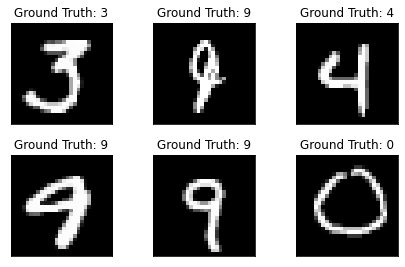

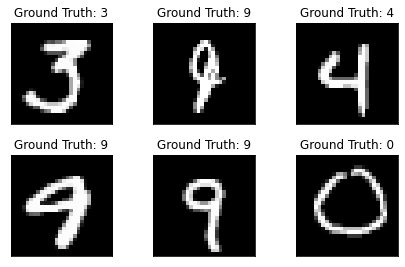

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [27]:
class MNISTNetwork(nn.Module):
    def __init__(self):
        super(MNISTNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) 

In [28]:
network = MNISTNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [29]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [30]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [31]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/var/folders/qs/mhsggvld4t1b9dry5p0xdg980000gn/T/ipykernel_34715/2861403526.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290954
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.318535
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.229576
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.181698
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088444
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.818533
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.822772
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838733
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.530556
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.738141
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.420971
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.369237
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.335397
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.182360
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.056649
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.381258
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.187307
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.325785
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.306794
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.459508
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.366085
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.408654
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.465794
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.315804
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.338349
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.258876
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.250093
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.244321
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.324436
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.211762
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.230573
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.359573
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.197789
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.420653
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.143219


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.192898
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.110632
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.208189
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.279432
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.596356
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.175178
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.237967
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.266167
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.269507
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.204436
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.151458
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.215777
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.313987
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.283380
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.176945
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.372423
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.254639
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.214596
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.703023
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.164210


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.288004
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.162352
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.194433
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.154246
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.277025
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.150165
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.216565
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.171584
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.350707
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.117896
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.210536
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.083702
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.231445
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.213021
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.394017
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.343018
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.140259
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.326901
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.165920
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.162893


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.104687
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.083271
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.171272
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.141525

Test set: Avg. loss: 0.0616, Accuracy: 9800/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.239154
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.220115
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.208588
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.302943
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.230782
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.069875
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.204490
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.129153
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.130103
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.165273
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.178700
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.133634
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.271318
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.173145
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.194360
Train Epoch: 8 [9600

Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.244515
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.130583
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.225003
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.124126
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.243269
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.209897
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.312787
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.128316
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.347832
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.162749
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.119850
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.203702
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.197442
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.144876
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.301860
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.224124
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.147753
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.082762
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.126515
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.132343


Train Epoch: 11 [24320/60000 (41%)]	Loss: 0.110258
Train Epoch: 11 [24960/60000 (42%)]	Loss: 0.144990
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.281143
Train Epoch: 11 [26240/60000 (44%)]	Loss: 0.276292
Train Epoch: 11 [26880/60000 (45%)]	Loss: 0.146969
Train Epoch: 11 [27520/60000 (46%)]	Loss: 0.061131
Train Epoch: 11 [28160/60000 (47%)]	Loss: 0.115180
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.085598
Train Epoch: 11 [29440/60000 (49%)]	Loss: 0.270793
Train Epoch: 11 [30080/60000 (50%)]	Loss: 0.119293
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.106283
Train Epoch: 11 [31360/60000 (52%)]	Loss: 0.150013
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.174987
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.240656
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.022438
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.360985
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.091803
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.423771
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.116303
Train Epoch: 11 [36480/60000 (6

Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.118937
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.081890
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.137578
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.195188
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.091322
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.322992
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.196379
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.108530
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.128696
Train Epoch: 13 [12160/60000 (20%)]	Loss: 0.137525
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.127333
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.146793
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.215858
Train Epoch: 13 [14720/60000 (25%)]	Loss: 0.111882
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.140887
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.298489
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.288162
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.248700
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.282048
Train Epoch: 13 [18560/60000 (31%)]	L

Train Epoch: 14 [49280/60000 (82%)]	Loss: 0.126959
Train Epoch: 14 [49920/60000 (83%)]	Loss: 0.052552
Train Epoch: 14 [50560/60000 (84%)]	Loss: 0.125357
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.129203
Train Epoch: 14 [51840/60000 (86%)]	Loss: 0.116429
Train Epoch: 14 [52480/60000 (87%)]	Loss: 0.162011
Train Epoch: 14 [53120/60000 (88%)]	Loss: 0.124866
Train Epoch: 14 [53760/60000 (90%)]	Loss: 0.216412
Train Epoch: 14 [54400/60000 (91%)]	Loss: 0.198246
Train Epoch: 14 [55040/60000 (92%)]	Loss: 0.056489
Train Epoch: 14 [55680/60000 (93%)]	Loss: 0.089251
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.288190
Train Epoch: 14 [56960/60000 (95%)]	Loss: 0.048022
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.071568
Train Epoch: 14 [58240/60000 (97%)]	Loss: 0.181346
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.054474
Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.148723

Test set: Avg. loss: 0.0443, Accuracy: 9855/10000 (99%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.119291
Train Epoch: 15 [640/60000 (1

Train Epoch: 16 [31360/60000 (52%)]	Loss: 0.142833
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.248823
Train Epoch: 16 [32640/60000 (54%)]	Loss: 0.282369
Train Epoch: 16 [33280/60000 (55%)]	Loss: 0.084359
Train Epoch: 16 [33920/60000 (57%)]	Loss: 0.385614
Train Epoch: 16 [34560/60000 (58%)]	Loss: 0.250370
Train Epoch: 16 [35200/60000 (59%)]	Loss: 0.132789
Train Epoch: 16 [35840/60000 (60%)]	Loss: 0.071441
Train Epoch: 16 [36480/60000 (61%)]	Loss: 0.178418
Train Epoch: 16 [37120/60000 (62%)]	Loss: 0.302150
Train Epoch: 16 [37760/60000 (63%)]	Loss: 0.063871
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.084199
Train Epoch: 16 [39040/60000 (65%)]	Loss: 0.062275
Train Epoch: 16 [39680/60000 (66%)]	Loss: 0.331369
Train Epoch: 16 [40320/60000 (67%)]	Loss: 0.281080
Train Epoch: 16 [40960/60000 (68%)]	Loss: 0.198218
Train Epoch: 16 [41600/60000 (69%)]	Loss: 0.084792
Train Epoch: 16 [42240/60000 (70%)]	Loss: 0.089619
Train Epoch: 16 [42880/60000 (71%)]	Loss: 0.197126
Train Epoch: 16 [43520/60000 (7

Train Epoch: 18 [13440/60000 (22%)]	Loss: 0.252413
Train Epoch: 18 [14080/60000 (23%)]	Loss: 0.185451
Train Epoch: 18 [14720/60000 (25%)]	Loss: 0.091924
Train Epoch: 18 [15360/60000 (26%)]	Loss: 0.197808
Train Epoch: 18 [16000/60000 (27%)]	Loss: 0.200798
Train Epoch: 18 [16640/60000 (28%)]	Loss: 0.121048
Train Epoch: 18 [17280/60000 (29%)]	Loss: 0.135629
Train Epoch: 18 [17920/60000 (30%)]	Loss: 0.112527
Train Epoch: 18 [18560/60000 (31%)]	Loss: 0.100523
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.034835
Train Epoch: 18 [19840/60000 (33%)]	Loss: 0.130682
Train Epoch: 18 [20480/60000 (34%)]	Loss: 0.172276
Train Epoch: 18 [21120/60000 (35%)]	Loss: 0.094091
Train Epoch: 18 [21760/60000 (36%)]	Loss: 0.132952
Train Epoch: 18 [22400/60000 (37%)]	Loss: 0.141666
Train Epoch: 18 [23040/60000 (38%)]	Loss: 0.148010
Train Epoch: 18 [23680/60000 (39%)]	Loss: 0.265567
Train Epoch: 18 [24320/60000 (41%)]	Loss: 0.134005
Train Epoch: 18 [24960/60000 (42%)]	Loss: 0.206378
Train Epoch: 18 [25600/60000 (4

Train Epoch: 19 [56320/60000 (94%)]	Loss: 0.124040
Train Epoch: 19 [56960/60000 (95%)]	Loss: 0.125014
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.021117
Train Epoch: 19 [58240/60000 (97%)]	Loss: 0.062532
Train Epoch: 19 [58880/60000 (98%)]	Loss: 0.417772
Train Epoch: 19 [59520/60000 (99%)]	Loss: 0.127814

Test set: Avg. loss: 0.0379, Accuracy: 9871/10000 (99%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.074414
Train Epoch: 20 [640/60000 (1%)]	Loss: 0.253949
Train Epoch: 20 [1280/60000 (2%)]	Loss: 0.057550
Train Epoch: 20 [1920/60000 (3%)]	Loss: 0.123400
Train Epoch: 20 [2560/60000 (4%)]	Loss: 0.191674
Train Epoch: 20 [3200/60000 (5%)]	Loss: 0.162845
Train Epoch: 20 [3840/60000 (6%)]	Loss: 0.129258
Train Epoch: 20 [4480/60000 (7%)]	Loss: 0.107933
Train Epoch: 20 [5120/60000 (9%)]	Loss: 0.163796
Train Epoch: 20 [5760/60000 (10%)]	Loss: 0.161945
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.275866
Train Epoch: 20 [7040/60000 (12%)]	Loss: 0.129938
Train Epoch: 20 [7680/60000 (13%)]	Loss: 0.085286

Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.145329
Train Epoch: 21 [39040/60000 (65%)]	Loss: 0.065992
Train Epoch: 21 [39680/60000 (66%)]	Loss: 0.169951
Train Epoch: 21 [40320/60000 (67%)]	Loss: 0.092781
Train Epoch: 21 [40960/60000 (68%)]	Loss: 0.130362
Train Epoch: 21 [41600/60000 (69%)]	Loss: 0.166732
Train Epoch: 21 [42240/60000 (70%)]	Loss: 0.109291
Train Epoch: 21 [42880/60000 (71%)]	Loss: 0.098788
Train Epoch: 21 [43520/60000 (72%)]	Loss: 0.111909
Train Epoch: 21 [44160/60000 (74%)]	Loss: 0.051453
Train Epoch: 21 [44800/60000 (75%)]	Loss: 0.203241
Train Epoch: 21 [45440/60000 (76%)]	Loss: 0.107612
Train Epoch: 21 [46080/60000 (77%)]	Loss: 0.082084
Train Epoch: 21 [46720/60000 (78%)]	Loss: 0.132205
Train Epoch: 21 [47360/60000 (79%)]	Loss: 0.084433
Train Epoch: 21 [48000/60000 (80%)]	Loss: 0.104531
Train Epoch: 21 [48640/60000 (81%)]	Loss: 0.148599
Train Epoch: 21 [49280/60000 (82%)]	Loss: 0.145130
Train Epoch: 21 [49920/60000 (83%)]	Loss: 0.113974
Train Epoch: 21 [50560/60000 (8

Train Epoch: 23 [20480/60000 (34%)]	Loss: 0.037055
Train Epoch: 23 [21120/60000 (35%)]	Loss: 0.240633
Train Epoch: 23 [21760/60000 (36%)]	Loss: 0.052567
Train Epoch: 23 [22400/60000 (37%)]	Loss: 0.103245
Train Epoch: 23 [23040/60000 (38%)]	Loss: 0.049950
Train Epoch: 23 [23680/60000 (39%)]	Loss: 0.207393
Train Epoch: 23 [24320/60000 (41%)]	Loss: 0.110496
Train Epoch: 23 [24960/60000 (42%)]	Loss: 0.236669
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.244936
Train Epoch: 23 [26240/60000 (44%)]	Loss: 0.120131
Train Epoch: 23 [26880/60000 (45%)]	Loss: 0.188150
Train Epoch: 23 [27520/60000 (46%)]	Loss: 0.186083
Train Epoch: 23 [28160/60000 (47%)]	Loss: 0.120635
Train Epoch: 23 [28800/60000 (48%)]	Loss: 0.054366
Train Epoch: 23 [29440/60000 (49%)]	Loss: 0.113764
Train Epoch: 23 [30080/60000 (50%)]	Loss: 0.135760
Train Epoch: 23 [30720/60000 (51%)]	Loss: 0.098947
Train Epoch: 23 [31360/60000 (52%)]	Loss: 0.217772
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.441123
Train Epoch: 23 [32640/60000 (5

Train Epoch: 25 [2560/60000 (4%)]	Loss: 0.166502
Train Epoch: 25 [3200/60000 (5%)]	Loss: 0.077979
Train Epoch: 25 [3840/60000 (6%)]	Loss: 0.065585
Train Epoch: 25 [4480/60000 (7%)]	Loss: 0.094320
Train Epoch: 25 [5120/60000 (9%)]	Loss: 0.068768
Train Epoch: 25 [5760/60000 (10%)]	Loss: 0.166997
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.258248
Train Epoch: 25 [7040/60000 (12%)]	Loss: 0.031116
Train Epoch: 25 [7680/60000 (13%)]	Loss: 0.261052
Train Epoch: 25 [8320/60000 (14%)]	Loss: 0.162148
Train Epoch: 25 [8960/60000 (15%)]	Loss: 0.253063
Train Epoch: 25 [9600/60000 (16%)]	Loss: 0.145895
Train Epoch: 25 [10240/60000 (17%)]	Loss: 0.091941
Train Epoch: 25 [10880/60000 (18%)]	Loss: 0.119403
Train Epoch: 25 [11520/60000 (19%)]	Loss: 0.030848
Train Epoch: 25 [12160/60000 (20%)]	Loss: 0.148986
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.066656
Train Epoch: 25 [13440/60000 (22%)]	Loss: 0.050162
Train Epoch: 25 [14080/60000 (23%)]	Loss: 0.053586
Train Epoch: 25 [14720/60000 (25%)]	Loss: 0.1280

Train Epoch: 26 [45440/60000 (76%)]	Loss: 0.116098
Train Epoch: 26 [46080/60000 (77%)]	Loss: 0.150359
Train Epoch: 26 [46720/60000 (78%)]	Loss: 0.080074
Train Epoch: 26 [47360/60000 (79%)]	Loss: 0.071092
Train Epoch: 26 [48000/60000 (80%)]	Loss: 0.091310
Train Epoch: 26 [48640/60000 (81%)]	Loss: 0.115654
Train Epoch: 26 [49280/60000 (82%)]	Loss: 0.076478
Train Epoch: 26 [49920/60000 (83%)]	Loss: 0.065071
Train Epoch: 26 [50560/60000 (84%)]	Loss: 0.082369
Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.124008
Train Epoch: 26 [51840/60000 (86%)]	Loss: 0.212093
Train Epoch: 26 [52480/60000 (87%)]	Loss: 0.112345
Train Epoch: 26 [53120/60000 (88%)]	Loss: 0.107097
Train Epoch: 26 [53760/60000 (90%)]	Loss: 0.210810
Train Epoch: 26 [54400/60000 (91%)]	Loss: 0.049620
Train Epoch: 26 [55040/60000 (92%)]	Loss: 0.025224
Train Epoch: 26 [55680/60000 (93%)]	Loss: 0.213469
Train Epoch: 26 [56320/60000 (94%)]	Loss: 0.066695
Train Epoch: 26 [56960/60000 (95%)]	Loss: 0.065634
Train Epoch: 26 [57600/60000 (9

Train Epoch: 28 [27520/60000 (46%)]	Loss: 0.072110
Train Epoch: 28 [28160/60000 (47%)]	Loss: 0.069065
Train Epoch: 28 [28800/60000 (48%)]	Loss: 0.028866
Train Epoch: 28 [29440/60000 (49%)]	Loss: 0.094476
Train Epoch: 28 [30080/60000 (50%)]	Loss: 0.221523
Train Epoch: 28 [30720/60000 (51%)]	Loss: 0.039087
Train Epoch: 28 [31360/60000 (52%)]	Loss: 0.074609
Train Epoch: 28 [32000/60000 (53%)]	Loss: 0.331959
Train Epoch: 28 [32640/60000 (54%)]	Loss: 0.175417
Train Epoch: 28 [33280/60000 (55%)]	Loss: 0.067245
Train Epoch: 28 [33920/60000 (57%)]	Loss: 0.080502
Train Epoch: 28 [34560/60000 (58%)]	Loss: 0.057529
Train Epoch: 28 [35200/60000 (59%)]	Loss: 0.060447
Train Epoch: 28 [35840/60000 (60%)]	Loss: 0.097019
Train Epoch: 28 [36480/60000 (61%)]	Loss: 0.183474
Train Epoch: 28 [37120/60000 (62%)]	Loss: 0.102335
Train Epoch: 28 [37760/60000 (63%)]	Loss: 0.076651
Train Epoch: 28 [38400/60000 (64%)]	Loss: 0.069868
Train Epoch: 28 [39040/60000 (65%)]	Loss: 0.109582
Train Epoch: 28 [39680/60000 (6

Train Epoch: 30 [9600/60000 (16%)]	Loss: 0.191292
Train Epoch: 30 [10240/60000 (17%)]	Loss: 0.219328
Train Epoch: 30 [10880/60000 (18%)]	Loss: 0.035510
Train Epoch: 30 [11520/60000 (19%)]	Loss: 0.054686
Train Epoch: 30 [12160/60000 (20%)]	Loss: 0.073589
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.072410
Train Epoch: 30 [13440/60000 (22%)]	Loss: 0.095812
Train Epoch: 30 [14080/60000 (23%)]	Loss: 0.059688
Train Epoch: 30 [14720/60000 (25%)]	Loss: 0.097614
Train Epoch: 30 [15360/60000 (26%)]	Loss: 0.144763
Train Epoch: 30 [16000/60000 (27%)]	Loss: 0.085282
Train Epoch: 30 [16640/60000 (28%)]	Loss: 0.049620
Train Epoch: 30 [17280/60000 (29%)]	Loss: 0.128439
Train Epoch: 30 [17920/60000 (30%)]	Loss: 0.025784
Train Epoch: 30 [18560/60000 (31%)]	Loss: 0.039934
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.068698
Train Epoch: 30 [19840/60000 (33%)]	Loss: 0.137256
Train Epoch: 30 [20480/60000 (34%)]	Loss: 0.044050
Train Epoch: 30 [21120/60000 (35%)]	Loss: 0.095078
Train Epoch: 30 [21760/60000 (36

Train Epoch: 31 [52480/60000 (87%)]	Loss: 0.263172
Train Epoch: 31 [53120/60000 (88%)]	Loss: 0.083748
Train Epoch: 31 [53760/60000 (90%)]	Loss: 0.036600
Train Epoch: 31 [54400/60000 (91%)]	Loss: 0.101002
Train Epoch: 31 [55040/60000 (92%)]	Loss: 0.045503
Train Epoch: 31 [55680/60000 (93%)]	Loss: 0.060859
Train Epoch: 31 [56320/60000 (94%)]	Loss: 0.112109
Train Epoch: 31 [56960/60000 (95%)]	Loss: 0.068053
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.104108
Train Epoch: 31 [58240/60000 (97%)]	Loss: 0.190519
Train Epoch: 31 [58880/60000 (98%)]	Loss: 0.138342
Train Epoch: 31 [59520/60000 (99%)]	Loss: 0.135450

Test set: Avg. loss: 0.0364, Accuracy: 9888/10000 (99%)

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.048671
Train Epoch: 32 [640/60000 (1%)]	Loss: 0.056949
Train Epoch: 32 [1280/60000 (2%)]	Loss: 0.118698
Train Epoch: 32 [1920/60000 (3%)]	Loss: 0.158731
Train Epoch: 32 [2560/60000 (4%)]	Loss: 0.188176
Train Epoch: 32 [3200/60000 (5%)]	Loss: 0.079751
Train Epoch: 32 [3840/60000 (6%)]	Loss: 

Train Epoch: 33 [34560/60000 (58%)]	Loss: 0.290567
Train Epoch: 33 [35200/60000 (59%)]	Loss: 0.013720
Train Epoch: 33 [35840/60000 (60%)]	Loss: 0.057459
Train Epoch: 33 [36480/60000 (61%)]	Loss: 0.063628
Train Epoch: 33 [37120/60000 (62%)]	Loss: 0.125316
Train Epoch: 33 [37760/60000 (63%)]	Loss: 0.076772
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.040859
Train Epoch: 33 [39040/60000 (65%)]	Loss: 0.069367
Train Epoch: 33 [39680/60000 (66%)]	Loss: 0.018528
Train Epoch: 33 [40320/60000 (67%)]	Loss: 0.018486
Train Epoch: 33 [40960/60000 (68%)]	Loss: 0.048491
Train Epoch: 33 [41600/60000 (69%)]	Loss: 0.152953
Train Epoch: 33 [42240/60000 (70%)]	Loss: 0.107870
Train Epoch: 33 [42880/60000 (71%)]	Loss: 0.034723
Train Epoch: 33 [43520/60000 (72%)]	Loss: 0.170080
Train Epoch: 33 [44160/60000 (74%)]	Loss: 0.122817
Train Epoch: 33 [44800/60000 (75%)]	Loss: 0.108182
Train Epoch: 33 [45440/60000 (76%)]	Loss: 0.134451
Train Epoch: 33 [46080/60000 (77%)]	Loss: 0.158540
Train Epoch: 33 [46720/60000 (7

Train Epoch: 35 [16640/60000 (28%)]	Loss: 0.066656
Train Epoch: 35 [17280/60000 (29%)]	Loss: 0.181396
Train Epoch: 35 [17920/60000 (30%)]	Loss: 0.074713
Train Epoch: 35 [18560/60000 (31%)]	Loss: 0.156982
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.114760
Train Epoch: 35 [19840/60000 (33%)]	Loss: 0.086213
Train Epoch: 35 [20480/60000 (34%)]	Loss: 0.048638
Train Epoch: 35 [21120/60000 (35%)]	Loss: 0.096954
Train Epoch: 35 [21760/60000 (36%)]	Loss: 0.061521
Train Epoch: 35 [22400/60000 (37%)]	Loss: 0.178134
Train Epoch: 35 [23040/60000 (38%)]	Loss: 0.119005
Train Epoch: 35 [23680/60000 (39%)]	Loss: 0.122741
Train Epoch: 35 [24320/60000 (41%)]	Loss: 0.136837
Train Epoch: 35 [24960/60000 (42%)]	Loss: 0.048049
Train Epoch: 35 [25600/60000 (43%)]	Loss: 0.110849
Train Epoch: 35 [26240/60000 (44%)]	Loss: 0.106309
Train Epoch: 35 [26880/60000 (45%)]	Loss: 0.116761
Train Epoch: 35 [27520/60000 (46%)]	Loss: 0.073781
Train Epoch: 35 [28160/60000 (47%)]	Loss: 0.093405
Train Epoch: 35 [28800/60000 (4

Train Epoch: 36 [59520/60000 (99%)]	Loss: 0.081377

Test set: Avg. loss: 0.0347, Accuracy: 9893/10000 (99%)

Train Epoch: 37 [0/60000 (0%)]	Loss: 0.046028
Train Epoch: 37 [640/60000 (1%)]	Loss: 0.097455
Train Epoch: 37 [1280/60000 (2%)]	Loss: 0.171070
Train Epoch: 37 [1920/60000 (3%)]	Loss: 0.053435
Train Epoch: 37 [2560/60000 (4%)]	Loss: 0.103638
Train Epoch: 37 [3200/60000 (5%)]	Loss: 0.180674
Train Epoch: 37 [3840/60000 (6%)]	Loss: 0.200324
Train Epoch: 37 [4480/60000 (7%)]	Loss: 0.053436
Train Epoch: 37 [5120/60000 (9%)]	Loss: 0.184543
Train Epoch: 37 [5760/60000 (10%)]	Loss: 0.148500
Train Epoch: 37 [6400/60000 (11%)]	Loss: 0.043782
Train Epoch: 37 [7040/60000 (12%)]	Loss: 0.066034
Train Epoch: 37 [7680/60000 (13%)]	Loss: 0.327307
Train Epoch: 37 [8320/60000 (14%)]	Loss: 0.097140
Train Epoch: 37 [8960/60000 (15%)]	Loss: 0.033920
Train Epoch: 37 [9600/60000 (16%)]	Loss: 0.285064
Train Epoch: 37 [10240/60000 (17%)]	Loss: 0.080852
Train Epoch: 37 [10880/60000 (18%)]	Loss: 0.181568
Tr

Train Epoch: 38 [41600/60000 (69%)]	Loss: 0.029761
Train Epoch: 38 [42240/60000 (70%)]	Loss: 0.110797
Train Epoch: 38 [42880/60000 (71%)]	Loss: 0.055806
Train Epoch: 38 [43520/60000 (72%)]	Loss: 0.026591
Train Epoch: 38 [44160/60000 (74%)]	Loss: 0.148423
Train Epoch: 38 [44800/60000 (75%)]	Loss: 0.104608
Train Epoch: 38 [45440/60000 (76%)]	Loss: 0.065844
Train Epoch: 38 [46080/60000 (77%)]	Loss: 0.162638
Train Epoch: 38 [46720/60000 (78%)]	Loss: 0.113174
Train Epoch: 38 [47360/60000 (79%)]	Loss: 0.037610
Train Epoch: 38 [48000/60000 (80%)]	Loss: 0.061858
Train Epoch: 38 [48640/60000 (81%)]	Loss: 0.091919
Train Epoch: 38 [49280/60000 (82%)]	Loss: 0.171209
Train Epoch: 38 [49920/60000 (83%)]	Loss: 0.067021
Train Epoch: 38 [50560/60000 (84%)]	Loss: 0.109273
Train Epoch: 38 [51200/60000 (85%)]	Loss: 0.104828
Train Epoch: 38 [51840/60000 (86%)]	Loss: 0.068347
Train Epoch: 38 [52480/60000 (87%)]	Loss: 0.028448
Train Epoch: 38 [53120/60000 (88%)]	Loss: 0.064663
Train Epoch: 38 [53760/60000 (9

Train Epoch: 40 [23680/60000 (39%)]	Loss: 0.082080
Train Epoch: 40 [24320/60000 (41%)]	Loss: 0.070172
Train Epoch: 40 [24960/60000 (42%)]	Loss: 0.109319
Train Epoch: 40 [25600/60000 (43%)]	Loss: 0.087608
Train Epoch: 40 [26240/60000 (44%)]	Loss: 0.105924
Train Epoch: 40 [26880/60000 (45%)]	Loss: 0.090444
Train Epoch: 40 [27520/60000 (46%)]	Loss: 0.115179
Train Epoch: 40 [28160/60000 (47%)]	Loss: 0.123441
Train Epoch: 40 [28800/60000 (48%)]	Loss: 0.212033
Train Epoch: 40 [29440/60000 (49%)]	Loss: 0.056808
Train Epoch: 40 [30080/60000 (50%)]	Loss: 0.127697
Train Epoch: 40 [30720/60000 (51%)]	Loss: 0.033598
Train Epoch: 40 [31360/60000 (52%)]	Loss: 0.233653
Train Epoch: 40 [32000/60000 (53%)]	Loss: 0.107558
Train Epoch: 40 [32640/60000 (54%)]	Loss: 0.161593
Train Epoch: 40 [33280/60000 (55%)]	Loss: 0.060006
Train Epoch: 40 [33920/60000 (57%)]	Loss: 0.113751
Train Epoch: 40 [34560/60000 (58%)]	Loss: 0.068028
Train Epoch: 40 [35200/60000 (59%)]	Loss: 0.063048
Train Epoch: 40 [35840/60000 (6

Train Epoch: 42 [5760/60000 (10%)]	Loss: 0.087737
Train Epoch: 42 [6400/60000 (11%)]	Loss: 0.128440
Train Epoch: 42 [7040/60000 (12%)]	Loss: 0.146284
Train Epoch: 42 [7680/60000 (13%)]	Loss: 0.021491
Train Epoch: 42 [8320/60000 (14%)]	Loss: 0.154394
Train Epoch: 42 [8960/60000 (15%)]	Loss: 0.131264
Train Epoch: 42 [9600/60000 (16%)]	Loss: 0.074466
Train Epoch: 42 [10240/60000 (17%)]	Loss: 0.054620
Train Epoch: 42 [10880/60000 (18%)]	Loss: 0.137409
Train Epoch: 42 [11520/60000 (19%)]	Loss: 0.128168
Train Epoch: 42 [12160/60000 (20%)]	Loss: 0.197399
Train Epoch: 42 [12800/60000 (21%)]	Loss: 0.097270
Train Epoch: 42 [13440/60000 (22%)]	Loss: 0.062201
Train Epoch: 42 [14080/60000 (23%)]	Loss: 0.061583
Train Epoch: 42 [14720/60000 (25%)]	Loss: 0.081947
Train Epoch: 42 [15360/60000 (26%)]	Loss: 0.258169
Train Epoch: 42 [16000/60000 (27%)]	Loss: 0.022290
Train Epoch: 42 [16640/60000 (28%)]	Loss: 0.089765
Train Epoch: 42 [17280/60000 (29%)]	Loss: 0.094526
Train Epoch: 42 [17920/60000 (30%)]	Lo

Train Epoch: 43 [48640/60000 (81%)]	Loss: 0.248812
Train Epoch: 43 [49280/60000 (82%)]	Loss: 0.049375
Train Epoch: 43 [49920/60000 (83%)]	Loss: 0.122639
Train Epoch: 43 [50560/60000 (84%)]	Loss: 0.072305
Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.042705
Train Epoch: 43 [51840/60000 (86%)]	Loss: 0.104629
Train Epoch: 43 [52480/60000 (87%)]	Loss: 0.095954
Train Epoch: 43 [53120/60000 (88%)]	Loss: 0.125159
Train Epoch: 43 [53760/60000 (90%)]	Loss: 0.078215
Train Epoch: 43 [54400/60000 (91%)]	Loss: 0.259052
Train Epoch: 43 [55040/60000 (92%)]	Loss: 0.227831
Train Epoch: 43 [55680/60000 (93%)]	Loss: 0.130459
Train Epoch: 43 [56320/60000 (94%)]	Loss: 0.183287
Train Epoch: 43 [56960/60000 (95%)]	Loss: 0.059517
Train Epoch: 43 [57600/60000 (96%)]	Loss: 0.065306
Train Epoch: 43 [58240/60000 (97%)]	Loss: 0.020641
Train Epoch: 43 [58880/60000 (98%)]	Loss: 0.071907
Train Epoch: 43 [59520/60000 (99%)]	Loss: 0.046003

Test set: Avg. loss: 0.0335, Accuracy: 9897/10000 (99%)

Train Epoch: 44 [0/60000

Train Epoch: 45 [30720/60000 (51%)]	Loss: 0.090527
Train Epoch: 45 [31360/60000 (52%)]	Loss: 0.234569
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.135401
Train Epoch: 45 [32640/60000 (54%)]	Loss: 0.052030
Train Epoch: 45 [33280/60000 (55%)]	Loss: 0.076954
Train Epoch: 45 [33920/60000 (57%)]	Loss: 0.074178
Train Epoch: 45 [34560/60000 (58%)]	Loss: 0.033446
Train Epoch: 45 [35200/60000 (59%)]	Loss: 0.019472
Train Epoch: 45 [35840/60000 (60%)]	Loss: 0.065479
Train Epoch: 45 [36480/60000 (61%)]	Loss: 0.140342
Train Epoch: 45 [37120/60000 (62%)]	Loss: 0.034454
Train Epoch: 45 [37760/60000 (63%)]	Loss: 0.040130
Train Epoch: 45 [38400/60000 (64%)]	Loss: 0.028600
Train Epoch: 45 [39040/60000 (65%)]	Loss: 0.117325
Train Epoch: 45 [39680/60000 (66%)]	Loss: 0.068933
Train Epoch: 45 [40320/60000 (67%)]	Loss: 0.081251
Train Epoch: 45 [40960/60000 (68%)]	Loss: 0.182225
Train Epoch: 45 [41600/60000 (69%)]	Loss: 0.045007
Train Epoch: 45 [42240/60000 (70%)]	Loss: 0.072917
Train Epoch: 45 [42880/60000 (7

Train Epoch: 47 [12800/60000 (21%)]	Loss: 0.113227
Train Epoch: 47 [13440/60000 (22%)]	Loss: 0.070364
Train Epoch: 47 [14080/60000 (23%)]	Loss: 0.115141
Train Epoch: 47 [14720/60000 (25%)]	Loss: 0.119408
Train Epoch: 47 [15360/60000 (26%)]	Loss: 0.113602
Train Epoch: 47 [16000/60000 (27%)]	Loss: 0.057603
Train Epoch: 47 [16640/60000 (28%)]	Loss: 0.077333
Train Epoch: 47 [17280/60000 (29%)]	Loss: 0.020974
Train Epoch: 47 [17920/60000 (30%)]	Loss: 0.122871
Train Epoch: 47 [18560/60000 (31%)]	Loss: 0.072225
Train Epoch: 47 [19200/60000 (32%)]	Loss: 0.091475
Train Epoch: 47 [19840/60000 (33%)]	Loss: 0.204300
Train Epoch: 47 [20480/60000 (34%)]	Loss: 0.140492
Train Epoch: 47 [21120/60000 (35%)]	Loss: 0.115549
Train Epoch: 47 [21760/60000 (36%)]	Loss: 0.110979
Train Epoch: 47 [22400/60000 (37%)]	Loss: 0.079903
Train Epoch: 47 [23040/60000 (38%)]	Loss: 0.063325
Train Epoch: 47 [23680/60000 (39%)]	Loss: 0.132150
Train Epoch: 47 [24320/60000 (41%)]	Loss: 0.105191
Train Epoch: 47 [24960/60000 (4

Train Epoch: 48 [55680/60000 (93%)]	Loss: 0.158182
Train Epoch: 48 [56320/60000 (94%)]	Loss: 0.043744
Train Epoch: 48 [56960/60000 (95%)]	Loss: 0.034772
Train Epoch: 48 [57600/60000 (96%)]	Loss: 0.103306
Train Epoch: 48 [58240/60000 (97%)]	Loss: 0.132224
Train Epoch: 48 [58880/60000 (98%)]	Loss: 0.071415
Train Epoch: 48 [59520/60000 (99%)]	Loss: 0.216890

Test set: Avg. loss: 0.0325, Accuracy: 9892/10000 (99%)

Train Epoch: 49 [0/60000 (0%)]	Loss: 0.083769
Train Epoch: 49 [640/60000 (1%)]	Loss: 0.038750
Train Epoch: 49 [1280/60000 (2%)]	Loss: 0.228325
Train Epoch: 49 [1920/60000 (3%)]	Loss: 0.060246
Train Epoch: 49 [2560/60000 (4%)]	Loss: 0.196897
Train Epoch: 49 [3200/60000 (5%)]	Loss: 0.077916
Train Epoch: 49 [3840/60000 (6%)]	Loss: 0.117616
Train Epoch: 49 [4480/60000 (7%)]	Loss: 0.089195
Train Epoch: 49 [5120/60000 (9%)]	Loss: 0.011307
Train Epoch: 49 [5760/60000 (10%)]	Loss: 0.067457
Train Epoch: 49 [6400/60000 (11%)]	Loss: 0.044694
Train Epoch: 49 [7040/60000 (12%)]	Loss: 0.09093

Train Epoch: 50 [37760/60000 (63%)]	Loss: 0.174749
Train Epoch: 50 [38400/60000 (64%)]	Loss: 0.232750
Train Epoch: 50 [39040/60000 (65%)]	Loss: 0.094842
Train Epoch: 50 [39680/60000 (66%)]	Loss: 0.028039
Train Epoch: 50 [40320/60000 (67%)]	Loss: 0.165908
Train Epoch: 50 [40960/60000 (68%)]	Loss: 0.097864
Train Epoch: 50 [41600/60000 (69%)]	Loss: 0.087223
Train Epoch: 50 [42240/60000 (70%)]	Loss: 0.011501
Train Epoch: 50 [42880/60000 (71%)]	Loss: 0.026136
Train Epoch: 50 [43520/60000 (72%)]	Loss: 0.080592
Train Epoch: 50 [44160/60000 (74%)]	Loss: 0.141232
Train Epoch: 50 [44800/60000 (75%)]	Loss: 0.149071
Train Epoch: 50 [45440/60000 (76%)]	Loss: 0.074376
Train Epoch: 50 [46080/60000 (77%)]	Loss: 0.151312
Train Epoch: 50 [46720/60000 (78%)]	Loss: 0.142759
Train Epoch: 50 [47360/60000 (79%)]	Loss: 0.082292
Train Epoch: 50 [48000/60000 (80%)]	Loss: 0.026423
Train Epoch: 50 [48640/60000 (81%)]	Loss: 0.146394
Train Epoch: 50 [49280/60000 (82%)]	Loss: 0.071047
Train Epoch: 50 [49920/60000 (8

Train Epoch: 52 [19840/60000 (33%)]	Loss: 0.106547
Train Epoch: 52 [20480/60000 (34%)]	Loss: 0.153628
Train Epoch: 52 [21120/60000 (35%)]	Loss: 0.119366
Train Epoch: 52 [21760/60000 (36%)]	Loss: 0.174072
Train Epoch: 52 [22400/60000 (37%)]	Loss: 0.041293
Train Epoch: 52 [23040/60000 (38%)]	Loss: 0.043860
Train Epoch: 52 [23680/60000 (39%)]	Loss: 0.146213
Train Epoch: 52 [24320/60000 (41%)]	Loss: 0.071240
Train Epoch: 52 [24960/60000 (42%)]	Loss: 0.068378
Train Epoch: 52 [25600/60000 (43%)]	Loss: 0.146906
Train Epoch: 52 [26240/60000 (44%)]	Loss: 0.088030
Train Epoch: 52 [26880/60000 (45%)]	Loss: 0.061984
Train Epoch: 52 [27520/60000 (46%)]	Loss: 0.049514
Train Epoch: 52 [28160/60000 (47%)]	Loss: 0.093784
Train Epoch: 52 [28800/60000 (48%)]	Loss: 0.077922
Train Epoch: 52 [29440/60000 (49%)]	Loss: 0.023410
Train Epoch: 52 [30080/60000 (50%)]	Loss: 0.086653
Train Epoch: 52 [30720/60000 (51%)]	Loss: 0.301826
Train Epoch: 52 [31360/60000 (52%)]	Loss: 0.095990
Train Epoch: 52 [32000/60000 (5

Train Epoch: 54 [1920/60000 (3%)]	Loss: 0.280802
Train Epoch: 54 [2560/60000 (4%)]	Loss: 0.069608
Train Epoch: 54 [3200/60000 (5%)]	Loss: 0.043316
Train Epoch: 54 [3840/60000 (6%)]	Loss: 0.092796
Train Epoch: 54 [4480/60000 (7%)]	Loss: 0.293380
Train Epoch: 54 [5120/60000 (9%)]	Loss: 0.018860
Train Epoch: 54 [5760/60000 (10%)]	Loss: 0.055266
Train Epoch: 54 [6400/60000 (11%)]	Loss: 0.113837
Train Epoch: 54 [7040/60000 (12%)]	Loss: 0.151816
Train Epoch: 54 [7680/60000 (13%)]	Loss: 0.049021
Train Epoch: 54 [8320/60000 (14%)]	Loss: 0.029116
Train Epoch: 54 [8960/60000 (15%)]	Loss: 0.034023
Train Epoch: 54 [9600/60000 (16%)]	Loss: 0.213842
Train Epoch: 54 [10240/60000 (17%)]	Loss: 0.069061
Train Epoch: 54 [10880/60000 (18%)]	Loss: 0.113670
Train Epoch: 54 [11520/60000 (19%)]	Loss: 0.128065
Train Epoch: 54 [12160/60000 (20%)]	Loss: 0.134521
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.048595
Train Epoch: 54 [13440/60000 (22%)]	Loss: 0.065971
Train Epoch: 54 [14080/60000 (23%)]	Loss: 0.057336

Train Epoch: 55 [44800/60000 (75%)]	Loss: 0.124549
Train Epoch: 55 [45440/60000 (76%)]	Loss: 0.084581
Train Epoch: 55 [46080/60000 (77%)]	Loss: 0.030828
Train Epoch: 55 [46720/60000 (78%)]	Loss: 0.036659
Train Epoch: 55 [47360/60000 (79%)]	Loss: 0.034304
Train Epoch: 55 [48000/60000 (80%)]	Loss: 0.046830
Train Epoch: 55 [48640/60000 (81%)]	Loss: 0.092461
Train Epoch: 55 [49280/60000 (82%)]	Loss: 0.131217
Train Epoch: 55 [49920/60000 (83%)]	Loss: 0.165794
Train Epoch: 55 [50560/60000 (84%)]	Loss: 0.116235
Train Epoch: 55 [51200/60000 (85%)]	Loss: 0.057444
Train Epoch: 55 [51840/60000 (86%)]	Loss: 0.098518
Train Epoch: 55 [52480/60000 (87%)]	Loss: 0.068784
Train Epoch: 55 [53120/60000 (88%)]	Loss: 0.070573
Train Epoch: 55 [53760/60000 (90%)]	Loss: 0.080646
Train Epoch: 55 [54400/60000 (91%)]	Loss: 0.068823
Train Epoch: 55 [55040/60000 (92%)]	Loss: 0.193193
Train Epoch: 55 [55680/60000 (93%)]	Loss: 0.162358
Train Epoch: 55 [56320/60000 (94%)]	Loss: 0.079115
Train Epoch: 55 [56960/60000 (9

Train Epoch: 57 [26880/60000 (45%)]	Loss: 0.163602
Train Epoch: 57 [27520/60000 (46%)]	Loss: 0.141666
Train Epoch: 57 [28160/60000 (47%)]	Loss: 0.062445
Train Epoch: 57 [28800/60000 (48%)]	Loss: 0.144192
Train Epoch: 57 [29440/60000 (49%)]	Loss: 0.052450
Train Epoch: 57 [30080/60000 (50%)]	Loss: 0.148230
Train Epoch: 57 [30720/60000 (51%)]	Loss: 0.078984
Train Epoch: 57 [31360/60000 (52%)]	Loss: 0.024839
Train Epoch: 57 [32000/60000 (53%)]	Loss: 0.045053
Train Epoch: 57 [32640/60000 (54%)]	Loss: 0.124634
Train Epoch: 57 [33280/60000 (55%)]	Loss: 0.121313
Train Epoch: 57 [33920/60000 (57%)]	Loss: 0.017110
Train Epoch: 57 [34560/60000 (58%)]	Loss: 0.311496
Train Epoch: 57 [35200/60000 (59%)]	Loss: 0.048936
Train Epoch: 57 [35840/60000 (60%)]	Loss: 0.084039
Train Epoch: 57 [36480/60000 (61%)]	Loss: 0.081787
Train Epoch: 57 [37120/60000 (62%)]	Loss: 0.050048
Train Epoch: 57 [37760/60000 (63%)]	Loss: 0.251546
Train Epoch: 57 [38400/60000 (64%)]	Loss: 0.222729
Train Epoch: 57 [39040/60000 (6

Train Epoch: 59 [8960/60000 (15%)]	Loss: 0.085237
Train Epoch: 59 [9600/60000 (16%)]	Loss: 0.076300
Train Epoch: 59 [10240/60000 (17%)]	Loss: 0.055668
Train Epoch: 59 [10880/60000 (18%)]	Loss: 0.017528
Train Epoch: 59 [11520/60000 (19%)]	Loss: 0.159011
Train Epoch: 59 [12160/60000 (20%)]	Loss: 0.074619
Train Epoch: 59 [12800/60000 (21%)]	Loss: 0.022750
Train Epoch: 59 [13440/60000 (22%)]	Loss: 0.065683
Train Epoch: 59 [14080/60000 (23%)]	Loss: 0.016626
Train Epoch: 59 [14720/60000 (25%)]	Loss: 0.077156
Train Epoch: 59 [15360/60000 (26%)]	Loss: 0.127852
Train Epoch: 59 [16000/60000 (27%)]	Loss: 0.099118
Train Epoch: 59 [16640/60000 (28%)]	Loss: 0.047636
Train Epoch: 59 [17280/60000 (29%)]	Loss: 0.095995
Train Epoch: 59 [17920/60000 (30%)]	Loss: 0.265271
Train Epoch: 59 [18560/60000 (31%)]	Loss: 0.046727
Train Epoch: 59 [19200/60000 (32%)]	Loss: 0.096041
Train Epoch: 59 [19840/60000 (33%)]	Loss: 0.037941
Train Epoch: 59 [20480/60000 (34%)]	Loss: 0.095634
Train Epoch: 59 [21120/60000 (35%

Train Epoch: 60 [51840/60000 (86%)]	Loss: 0.068094
Train Epoch: 60 [52480/60000 (87%)]	Loss: 0.026056
Train Epoch: 60 [53120/60000 (88%)]	Loss: 0.086216
Train Epoch: 60 [53760/60000 (90%)]	Loss: 0.045864
Train Epoch: 60 [54400/60000 (91%)]	Loss: 0.036945
Train Epoch: 60 [55040/60000 (92%)]	Loss: 0.107884
Train Epoch: 60 [55680/60000 (93%)]	Loss: 0.114677
Train Epoch: 60 [56320/60000 (94%)]	Loss: 0.055642
Train Epoch: 60 [56960/60000 (95%)]	Loss: 0.138162
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.030918
Train Epoch: 60 [58240/60000 (97%)]	Loss: 0.159184
Train Epoch: 60 [58880/60000 (98%)]	Loss: 0.138001
Train Epoch: 60 [59520/60000 (99%)]	Loss: 0.083368

Test set: Avg. loss: 0.0310, Accuracy: 9901/10000 (99%)

Train Epoch: 61 [0/60000 (0%)]	Loss: 0.131467
Train Epoch: 61 [640/60000 (1%)]	Loss: 0.059884
Train Epoch: 61 [1280/60000 (2%)]	Loss: 0.081118
Train Epoch: 61 [1920/60000 (3%)]	Loss: 0.069261
Train Epoch: 61 [2560/60000 (4%)]	Loss: 0.033371
Train Epoch: 61 [3200/60000 (5%)]	Loss

Train Epoch: 62 [33920/60000 (57%)]	Loss: 0.092668
Train Epoch: 62 [34560/60000 (58%)]	Loss: 0.279371
Train Epoch: 62 [35200/60000 (59%)]	Loss: 0.086768
Train Epoch: 62 [35840/60000 (60%)]	Loss: 0.093366
Train Epoch: 62 [36480/60000 (61%)]	Loss: 0.089782
Train Epoch: 62 [37120/60000 (62%)]	Loss: 0.049501
Train Epoch: 62 [37760/60000 (63%)]	Loss: 0.173853
Train Epoch: 62 [38400/60000 (64%)]	Loss: 0.187524
Train Epoch: 62 [39040/60000 (65%)]	Loss: 0.069732
Train Epoch: 62 [39680/60000 (66%)]	Loss: 0.071925
Train Epoch: 62 [40320/60000 (67%)]	Loss: 0.114718
Train Epoch: 62 [40960/60000 (68%)]	Loss: 0.068453
Train Epoch: 62 [41600/60000 (69%)]	Loss: 0.062424
Train Epoch: 62 [42240/60000 (70%)]	Loss: 0.367172
Train Epoch: 62 [42880/60000 (71%)]	Loss: 0.088274
Train Epoch: 62 [43520/60000 (72%)]	Loss: 0.130566
Train Epoch: 62 [44160/60000 (74%)]	Loss: 0.049890
Train Epoch: 62 [44800/60000 (75%)]	Loss: 0.098749
Train Epoch: 62 [45440/60000 (76%)]	Loss: 0.051347
Train Epoch: 62 [46080/60000 (7

Train Epoch: 64 [16000/60000 (27%)]	Loss: 0.059309
Train Epoch: 64 [16640/60000 (28%)]	Loss: 0.032255
Train Epoch: 64 [17280/60000 (29%)]	Loss: 0.261079
Train Epoch: 64 [17920/60000 (30%)]	Loss: 0.260336
Train Epoch: 64 [18560/60000 (31%)]	Loss: 0.079266
Train Epoch: 64 [19200/60000 (32%)]	Loss: 0.041444
Train Epoch: 64 [19840/60000 (33%)]	Loss: 0.168795
Train Epoch: 64 [20480/60000 (34%)]	Loss: 0.160412
Train Epoch: 64 [21120/60000 (35%)]	Loss: 0.050665
Train Epoch: 64 [21760/60000 (36%)]	Loss: 0.197084
Train Epoch: 64 [22400/60000 (37%)]	Loss: 0.052063
Train Epoch: 64 [23040/60000 (38%)]	Loss: 0.031500
Train Epoch: 64 [23680/60000 (39%)]	Loss: 0.032466
Train Epoch: 64 [24320/60000 (41%)]	Loss: 0.037032
Train Epoch: 64 [24960/60000 (42%)]	Loss: 0.075517
Train Epoch: 64 [25600/60000 (43%)]	Loss: 0.028833
Train Epoch: 64 [26240/60000 (44%)]	Loss: 0.058976
Train Epoch: 64 [26880/60000 (45%)]	Loss: 0.016580
Train Epoch: 64 [27520/60000 (46%)]	Loss: 0.290091
Train Epoch: 64 [28160/60000 (4

Train Epoch: 65 [58880/60000 (98%)]	Loss: 0.088933
Train Epoch: 65 [59520/60000 (99%)]	Loss: 0.119150

Test set: Avg. loss: 0.0306, Accuracy: 9904/10000 (99%)

Train Epoch: 66 [0/60000 (0%)]	Loss: 0.083850
Train Epoch: 66 [640/60000 (1%)]	Loss: 0.096813
Train Epoch: 66 [1280/60000 (2%)]	Loss: 0.047813
Train Epoch: 66 [1920/60000 (3%)]	Loss: 0.087411
Train Epoch: 66 [2560/60000 (4%)]	Loss: 0.052077
Train Epoch: 66 [3200/60000 (5%)]	Loss: 0.056041
Train Epoch: 66 [3840/60000 (6%)]	Loss: 0.062480
Train Epoch: 66 [4480/60000 (7%)]	Loss: 0.049647
Train Epoch: 66 [5120/60000 (9%)]	Loss: 0.063618
Train Epoch: 66 [5760/60000 (10%)]	Loss: 0.035264
Train Epoch: 66 [6400/60000 (11%)]	Loss: 0.120355
Train Epoch: 66 [7040/60000 (12%)]	Loss: 0.053683
Train Epoch: 66 [7680/60000 (13%)]	Loss: 0.059866
Train Epoch: 66 [8320/60000 (14%)]	Loss: 0.021752
Train Epoch: 66 [8960/60000 (15%)]	Loss: 0.083238
Train Epoch: 66 [9600/60000 (16%)]	Loss: 0.045481
Train Epoch: 66 [10240/60000 (17%)]	Loss: 0.038059
Tr

Train Epoch: 67 [40960/60000 (68%)]	Loss: 0.124687
Train Epoch: 67 [41600/60000 (69%)]	Loss: 0.181554
Train Epoch: 67 [42240/60000 (70%)]	Loss: 0.043392
Train Epoch: 67 [42880/60000 (71%)]	Loss: 0.007806
Train Epoch: 67 [43520/60000 (72%)]	Loss: 0.054163
Train Epoch: 67 [44160/60000 (74%)]	Loss: 0.050666
Train Epoch: 67 [44800/60000 (75%)]	Loss: 0.045895
Train Epoch: 67 [45440/60000 (76%)]	Loss: 0.215897
Train Epoch: 67 [46080/60000 (77%)]	Loss: 0.119681
Train Epoch: 67 [46720/60000 (78%)]	Loss: 0.089862
Train Epoch: 67 [47360/60000 (79%)]	Loss: 0.024987
Train Epoch: 67 [48000/60000 (80%)]	Loss: 0.051588
Train Epoch: 67 [48640/60000 (81%)]	Loss: 0.093135
Train Epoch: 67 [49280/60000 (82%)]	Loss: 0.181619
Train Epoch: 67 [49920/60000 (83%)]	Loss: 0.264299
Train Epoch: 67 [50560/60000 (84%)]	Loss: 0.052921
Train Epoch: 67 [51200/60000 (85%)]	Loss: 0.081114
Train Epoch: 67 [51840/60000 (86%)]	Loss: 0.017981
Train Epoch: 67 [52480/60000 (87%)]	Loss: 0.171833
Train Epoch: 67 [53120/60000 (8

Train Epoch: 69 [23040/60000 (38%)]	Loss: 0.146009
Train Epoch: 69 [23680/60000 (39%)]	Loss: 0.060092
Train Epoch: 69 [24320/60000 (41%)]	Loss: 0.047522
Train Epoch: 69 [24960/60000 (42%)]	Loss: 0.090406
Train Epoch: 69 [25600/60000 (43%)]	Loss: 0.184895
Train Epoch: 69 [26240/60000 (44%)]	Loss: 0.106023
Train Epoch: 69 [26880/60000 (45%)]	Loss: 0.027242
Train Epoch: 69 [27520/60000 (46%)]	Loss: 0.155501
Train Epoch: 69 [28160/60000 (47%)]	Loss: 0.131655
Train Epoch: 69 [28800/60000 (48%)]	Loss: 0.053856
Train Epoch: 69 [29440/60000 (49%)]	Loss: 0.113317
Train Epoch: 69 [30080/60000 (50%)]	Loss: 0.039777
Train Epoch: 69 [30720/60000 (51%)]	Loss: 0.195570
Train Epoch: 69 [31360/60000 (52%)]	Loss: 0.054536
Train Epoch: 69 [32000/60000 (53%)]	Loss: 0.126668
Train Epoch: 69 [32640/60000 (54%)]	Loss: 0.080593
Train Epoch: 69 [33280/60000 (55%)]	Loss: 0.066025
Train Epoch: 69 [33920/60000 (57%)]	Loss: 0.123230
Train Epoch: 69 [34560/60000 (58%)]	Loss: 0.089860
Train Epoch: 69 [35200/60000 (5

Train Epoch: 71 [5120/60000 (9%)]	Loss: 0.047170
Train Epoch: 71 [5760/60000 (10%)]	Loss: 0.079113
Train Epoch: 71 [6400/60000 (11%)]	Loss: 0.046827
Train Epoch: 71 [7040/60000 (12%)]	Loss: 0.262155
Train Epoch: 71 [7680/60000 (13%)]	Loss: 0.039468
Train Epoch: 71 [8320/60000 (14%)]	Loss: 0.006568
Train Epoch: 71 [8960/60000 (15%)]	Loss: 0.078743
Train Epoch: 71 [9600/60000 (16%)]	Loss: 0.082713
Train Epoch: 71 [10240/60000 (17%)]	Loss: 0.053550
Train Epoch: 71 [10880/60000 (18%)]	Loss: 0.100447
Train Epoch: 71 [11520/60000 (19%)]	Loss: 0.016173
Train Epoch: 71 [12160/60000 (20%)]	Loss: 0.081256
Train Epoch: 71 [12800/60000 (21%)]	Loss: 0.119274
Train Epoch: 71 [13440/60000 (22%)]	Loss: 0.065544
Train Epoch: 71 [14080/60000 (23%)]	Loss: 0.078478
Train Epoch: 71 [14720/60000 (25%)]	Loss: 0.032566
Train Epoch: 71 [15360/60000 (26%)]	Loss: 0.036623
Train Epoch: 71 [16000/60000 (27%)]	Loss: 0.079705
Train Epoch: 71 [16640/60000 (28%)]	Loss: 0.098688
Train Epoch: 71 [17280/60000 (29%)]	Loss

Train Epoch: 72 [48000/60000 (80%)]	Loss: 0.152328
Train Epoch: 72 [48640/60000 (81%)]	Loss: 0.096157
Train Epoch: 72 [49280/60000 (82%)]	Loss: 0.074672
Train Epoch: 72 [49920/60000 (83%)]	Loss: 0.066261
Train Epoch: 72 [50560/60000 (84%)]	Loss: 0.122150
Train Epoch: 72 [51200/60000 (85%)]	Loss: 0.252903
Train Epoch: 72 [51840/60000 (86%)]	Loss: 0.049450
Train Epoch: 72 [52480/60000 (87%)]	Loss: 0.332226
Train Epoch: 72 [53120/60000 (88%)]	Loss: 0.102777
Train Epoch: 72 [53760/60000 (90%)]	Loss: 0.101127
Train Epoch: 72 [54400/60000 (91%)]	Loss: 0.098829
Train Epoch: 72 [55040/60000 (92%)]	Loss: 0.166221
Train Epoch: 72 [55680/60000 (93%)]	Loss: 0.159089
Train Epoch: 72 [56320/60000 (94%)]	Loss: 0.033711
Train Epoch: 72 [56960/60000 (95%)]	Loss: 0.090473
Train Epoch: 72 [57600/60000 (96%)]	Loss: 0.197176
Train Epoch: 72 [58240/60000 (97%)]	Loss: 0.062376
Train Epoch: 72 [58880/60000 (98%)]	Loss: 0.054561
Train Epoch: 72 [59520/60000 (99%)]	Loss: 0.054481

Test set: Avg. loss: 0.0292, A

Train Epoch: 74 [30080/60000 (50%)]	Loss: 0.149693
Train Epoch: 74 [30720/60000 (51%)]	Loss: 0.107344
Train Epoch: 74 [31360/60000 (52%)]	Loss: 0.224552
Train Epoch: 74 [32000/60000 (53%)]	Loss: 0.035702
Train Epoch: 74 [32640/60000 (54%)]	Loss: 0.087054
Train Epoch: 74 [33280/60000 (55%)]	Loss: 0.036513
Train Epoch: 74 [33920/60000 (57%)]	Loss: 0.090517
Train Epoch: 74 [34560/60000 (58%)]	Loss: 0.010421
Train Epoch: 74 [35200/60000 (59%)]	Loss: 0.039852
Train Epoch: 74 [35840/60000 (60%)]	Loss: 0.223427
Train Epoch: 74 [36480/60000 (61%)]	Loss: 0.012037
Train Epoch: 74 [37120/60000 (62%)]	Loss: 0.277561
Train Epoch: 74 [37760/60000 (63%)]	Loss: 0.259802
Train Epoch: 74 [38400/60000 (64%)]	Loss: 0.102486
Train Epoch: 74 [39040/60000 (65%)]	Loss: 0.022511
Train Epoch: 74 [39680/60000 (66%)]	Loss: 0.044823
Train Epoch: 74 [40320/60000 (67%)]	Loss: 0.081750
Train Epoch: 74 [40960/60000 (68%)]	Loss: 0.084484
Train Epoch: 74 [41600/60000 (69%)]	Loss: 0.202081
Train Epoch: 74 [42240/60000 (7

Train Epoch: 76 [12160/60000 (20%)]	Loss: 0.077458
Train Epoch: 76 [12800/60000 (21%)]	Loss: 0.014605
Train Epoch: 76 [13440/60000 (22%)]	Loss: 0.140006
Train Epoch: 76 [14080/60000 (23%)]	Loss: 0.057905
Train Epoch: 76 [14720/60000 (25%)]	Loss: 0.130646
Train Epoch: 76 [15360/60000 (26%)]	Loss: 0.133443
Train Epoch: 76 [16000/60000 (27%)]	Loss: 0.026716
Train Epoch: 76 [16640/60000 (28%)]	Loss: 0.027476
Train Epoch: 76 [17280/60000 (29%)]	Loss: 0.050023
Train Epoch: 76 [17920/60000 (30%)]	Loss: 0.226794
Train Epoch: 76 [18560/60000 (31%)]	Loss: 0.055270
Train Epoch: 76 [19200/60000 (32%)]	Loss: 0.185129
Train Epoch: 76 [19840/60000 (33%)]	Loss: 0.108642
Train Epoch: 76 [20480/60000 (34%)]	Loss: 0.080874
Train Epoch: 76 [21120/60000 (35%)]	Loss: 0.182224
Train Epoch: 76 [21760/60000 (36%)]	Loss: 0.031430
Train Epoch: 76 [22400/60000 (37%)]	Loss: 0.024505
Train Epoch: 76 [23040/60000 (38%)]	Loss: 0.070429
Train Epoch: 76 [23680/60000 (39%)]	Loss: 0.094472
Train Epoch: 76 [24320/60000 (4

Train Epoch: 77 [55040/60000 (92%)]	Loss: 0.097365
Train Epoch: 77 [55680/60000 (93%)]	Loss: 0.027461
Train Epoch: 77 [56320/60000 (94%)]	Loss: 0.044714
Train Epoch: 77 [56960/60000 (95%)]	Loss: 0.079714
Train Epoch: 77 [57600/60000 (96%)]	Loss: 0.136718
Train Epoch: 77 [58240/60000 (97%)]	Loss: 0.144173
Train Epoch: 77 [58880/60000 (98%)]	Loss: 0.170172
Train Epoch: 77 [59520/60000 (99%)]	Loss: 0.098391

Test set: Avg. loss: 0.0312, Accuracy: 9904/10000 (99%)

Train Epoch: 78 [0/60000 (0%)]	Loss: 0.101936
Train Epoch: 78 [640/60000 (1%)]	Loss: 0.024207
Train Epoch: 78 [1280/60000 (2%)]	Loss: 0.072905
Train Epoch: 78 [1920/60000 (3%)]	Loss: 0.038939
Train Epoch: 78 [2560/60000 (4%)]	Loss: 0.161683
Train Epoch: 78 [3200/60000 (5%)]	Loss: 0.020578
Train Epoch: 78 [3840/60000 (6%)]	Loss: 0.087466
Train Epoch: 78 [4480/60000 (7%)]	Loss: 0.067310
Train Epoch: 78 [5120/60000 (9%)]	Loss: 0.123283
Train Epoch: 78 [5760/60000 (10%)]	Loss: 0.012190
Train Epoch: 78 [6400/60000 (11%)]	Loss: 0.0805

Train Epoch: 79 [37120/60000 (62%)]	Loss: 0.027476
Train Epoch: 79 [37760/60000 (63%)]	Loss: 0.123476
Train Epoch: 79 [38400/60000 (64%)]	Loss: 0.058050
Train Epoch: 79 [39040/60000 (65%)]	Loss: 0.112542
Train Epoch: 79 [39680/60000 (66%)]	Loss: 0.008637
Train Epoch: 79 [40320/60000 (67%)]	Loss: 0.169813
Train Epoch: 79 [40960/60000 (68%)]	Loss: 0.101117
Train Epoch: 79 [41600/60000 (69%)]	Loss: 0.115253
Train Epoch: 79 [42240/60000 (70%)]	Loss: 0.035236
Train Epoch: 79 [42880/60000 (71%)]	Loss: 0.071090
Train Epoch: 79 [43520/60000 (72%)]	Loss: 0.184942
Train Epoch: 79 [44160/60000 (74%)]	Loss: 0.187410
Train Epoch: 79 [44800/60000 (75%)]	Loss: 0.058463
Train Epoch: 79 [45440/60000 (76%)]	Loss: 0.043376
Train Epoch: 79 [46080/60000 (77%)]	Loss: 0.049445
Train Epoch: 79 [46720/60000 (78%)]	Loss: 0.038535
Train Epoch: 79 [47360/60000 (79%)]	Loss: 0.053200
Train Epoch: 79 [48000/60000 (80%)]	Loss: 0.018244
Train Epoch: 79 [48640/60000 (81%)]	Loss: 0.070017
Train Epoch: 79 [49280/60000 (8

Train Epoch: 81 [19200/60000 (32%)]	Loss: 0.059281
Train Epoch: 81 [19840/60000 (33%)]	Loss: 0.080446
Train Epoch: 81 [20480/60000 (34%)]	Loss: 0.125667
Train Epoch: 81 [21120/60000 (35%)]	Loss: 0.058117
Train Epoch: 81 [21760/60000 (36%)]	Loss: 0.055299
Train Epoch: 81 [22400/60000 (37%)]	Loss: 0.185658
Train Epoch: 81 [23040/60000 (38%)]	Loss: 0.151766
Train Epoch: 81 [23680/60000 (39%)]	Loss: 0.175794
Train Epoch: 81 [24320/60000 (41%)]	Loss: 0.050750
Train Epoch: 81 [24960/60000 (42%)]	Loss: 0.049258
Train Epoch: 81 [25600/60000 (43%)]	Loss: 0.188527
Train Epoch: 81 [26240/60000 (44%)]	Loss: 0.100334
Train Epoch: 81 [26880/60000 (45%)]	Loss: 0.205194
Train Epoch: 81 [27520/60000 (46%)]	Loss: 0.127577
Train Epoch: 81 [28160/60000 (47%)]	Loss: 0.042632
Train Epoch: 81 [28800/60000 (48%)]	Loss: 0.136568
Train Epoch: 81 [29440/60000 (49%)]	Loss: 0.033840
Train Epoch: 81 [30080/60000 (50%)]	Loss: 0.138745
Train Epoch: 81 [30720/60000 (51%)]	Loss: 0.304128
Train Epoch: 81 [31360/60000 (5

Train Epoch: 83 [1280/60000 (2%)]	Loss: 0.040017
Train Epoch: 83 [1920/60000 (3%)]	Loss: 0.048982
Train Epoch: 83 [2560/60000 (4%)]	Loss: 0.071004
Train Epoch: 83 [3200/60000 (5%)]	Loss: 0.188829
Train Epoch: 83 [3840/60000 (6%)]	Loss: 0.071949
Train Epoch: 83 [4480/60000 (7%)]	Loss: 0.141351
Train Epoch: 83 [5120/60000 (9%)]	Loss: 0.092047
Train Epoch: 83 [5760/60000 (10%)]	Loss: 0.052767
Train Epoch: 83 [6400/60000 (11%)]	Loss: 0.055557
Train Epoch: 83 [7040/60000 (12%)]	Loss: 0.110244
Train Epoch: 83 [7680/60000 (13%)]	Loss: 0.048614
Train Epoch: 83 [8320/60000 (14%)]	Loss: 0.275086
Train Epoch: 83 [8960/60000 (15%)]	Loss: 0.069985
Train Epoch: 83 [9600/60000 (16%)]	Loss: 0.193188
Train Epoch: 83 [10240/60000 (17%)]	Loss: 0.129286
Train Epoch: 83 [10880/60000 (18%)]	Loss: 0.059562
Train Epoch: 83 [11520/60000 (19%)]	Loss: 0.090511
Train Epoch: 83 [12160/60000 (20%)]	Loss: 0.182127
Train Epoch: 83 [12800/60000 (21%)]	Loss: 0.041668
Train Epoch: 83 [13440/60000 (22%)]	Loss: 0.008709
T

Train Epoch: 84 [44160/60000 (74%)]	Loss: 0.086192
Train Epoch: 84 [44800/60000 (75%)]	Loss: 0.170069
Train Epoch: 84 [45440/60000 (76%)]	Loss: 0.141400
Train Epoch: 84 [46080/60000 (77%)]	Loss: 0.030013
Train Epoch: 84 [46720/60000 (78%)]	Loss: 0.121787
Train Epoch: 84 [47360/60000 (79%)]	Loss: 0.107716
Train Epoch: 84 [48000/60000 (80%)]	Loss: 0.048303
Train Epoch: 84 [48640/60000 (81%)]	Loss: 0.056360
Train Epoch: 84 [49280/60000 (82%)]	Loss: 0.131882
Train Epoch: 84 [49920/60000 (83%)]	Loss: 0.063283
Train Epoch: 84 [50560/60000 (84%)]	Loss: 0.036407
Train Epoch: 84 [51200/60000 (85%)]	Loss: 0.062739
Train Epoch: 84 [51840/60000 (86%)]	Loss: 0.142339
Train Epoch: 84 [52480/60000 (87%)]	Loss: 0.043286
Train Epoch: 84 [53120/60000 (88%)]	Loss: 0.065164
Train Epoch: 84 [53760/60000 (90%)]	Loss: 0.142042
Train Epoch: 84 [54400/60000 (91%)]	Loss: 0.064327
Train Epoch: 84 [55040/60000 (92%)]	Loss: 0.050925
Train Epoch: 84 [55680/60000 (93%)]	Loss: 0.107519
Train Epoch: 84 [56320/60000 (9

Train Epoch: 86 [26240/60000 (44%)]	Loss: 0.037676
Train Epoch: 86 [26880/60000 (45%)]	Loss: 0.073468
Train Epoch: 86 [27520/60000 (46%)]	Loss: 0.121788
Train Epoch: 86 [28160/60000 (47%)]	Loss: 0.082718
Train Epoch: 86 [28800/60000 (48%)]	Loss: 0.028445
Train Epoch: 86 [29440/60000 (49%)]	Loss: 0.078591
Train Epoch: 86 [30080/60000 (50%)]	Loss: 0.143402
Train Epoch: 86 [30720/60000 (51%)]	Loss: 0.090110
Train Epoch: 86 [31360/60000 (52%)]	Loss: 0.025873
Train Epoch: 86 [32000/60000 (53%)]	Loss: 0.217636
Train Epoch: 86 [32640/60000 (54%)]	Loss: 0.263181
Train Epoch: 86 [33280/60000 (55%)]	Loss: 0.049083
Train Epoch: 86 [33920/60000 (57%)]	Loss: 0.033240
Train Epoch: 86 [34560/60000 (58%)]	Loss: 0.068404
Train Epoch: 86 [35200/60000 (59%)]	Loss: 0.051220
Train Epoch: 86 [35840/60000 (60%)]	Loss: 0.173718
Train Epoch: 86 [36480/60000 (61%)]	Loss: 0.026814
Train Epoch: 86 [37120/60000 (62%)]	Loss: 0.235404
Train Epoch: 86 [37760/60000 (63%)]	Loss: 0.117678
Train Epoch: 86 [38400/60000 (6

Train Epoch: 88 [8320/60000 (14%)]	Loss: 0.070775
Train Epoch: 88 [8960/60000 (15%)]	Loss: 0.104354
Train Epoch: 88 [9600/60000 (16%)]	Loss: 0.056104
Train Epoch: 88 [10240/60000 (17%)]	Loss: 0.101011
Train Epoch: 88 [10880/60000 (18%)]	Loss: 0.093504
Train Epoch: 88 [11520/60000 (19%)]	Loss: 0.134798
Train Epoch: 88 [12160/60000 (20%)]	Loss: 0.106294
Train Epoch: 88 [12800/60000 (21%)]	Loss: 0.069721
Train Epoch: 88 [13440/60000 (22%)]	Loss: 0.088321
Train Epoch: 88 [14080/60000 (23%)]	Loss: 0.103041
Train Epoch: 88 [14720/60000 (25%)]	Loss: 0.030777
Train Epoch: 88 [15360/60000 (26%)]	Loss: 0.047368
Train Epoch: 88 [16000/60000 (27%)]	Loss: 0.055464
Train Epoch: 88 [16640/60000 (28%)]	Loss: 0.057571
Train Epoch: 88 [17280/60000 (29%)]	Loss: 0.074813
Train Epoch: 88 [17920/60000 (30%)]	Loss: 0.151701
Train Epoch: 88 [18560/60000 (31%)]	Loss: 0.057570
Train Epoch: 88 [19200/60000 (32%)]	Loss: 0.125060
Train Epoch: 88 [19840/60000 (33%)]	Loss: 0.084397
Train Epoch: 88 [20480/60000 (34%)

Train Epoch: 89 [51200/60000 (85%)]	Loss: 0.135569
Train Epoch: 89 [51840/60000 (86%)]	Loss: 0.103867
Train Epoch: 89 [52480/60000 (87%)]	Loss: 0.058359
Train Epoch: 89 [53120/60000 (88%)]	Loss: 0.139251
Train Epoch: 89 [53760/60000 (90%)]	Loss: 0.048549
Train Epoch: 89 [54400/60000 (91%)]	Loss: 0.133088
Train Epoch: 89 [55040/60000 (92%)]	Loss: 0.065438
Train Epoch: 89 [55680/60000 (93%)]	Loss: 0.062357
Train Epoch: 89 [56320/60000 (94%)]	Loss: 0.115640
Train Epoch: 89 [56960/60000 (95%)]	Loss: 0.027403
Train Epoch: 89 [57600/60000 (96%)]	Loss: 0.261389
Train Epoch: 89 [58240/60000 (97%)]	Loss: 0.023121
Train Epoch: 89 [58880/60000 (98%)]	Loss: 0.079421
Train Epoch: 89 [59520/60000 (99%)]	Loss: 0.070865

Test set: Avg. loss: 0.0304, Accuracy: 9902/10000 (99%)

Train Epoch: 90 [0/60000 (0%)]	Loss: 0.015573
Train Epoch: 90 [640/60000 (1%)]	Loss: 0.030797
Train Epoch: 90 [1280/60000 (2%)]	Loss: 0.043032
Train Epoch: 90 [1920/60000 (3%)]	Loss: 0.137770
Train Epoch: 90 [2560/60000 (4%)]	Lo

Train Epoch: 91 [33280/60000 (55%)]	Loss: 0.047558
Train Epoch: 91 [33920/60000 (57%)]	Loss: 0.023490
Train Epoch: 91 [34560/60000 (58%)]	Loss: 0.321906
Train Epoch: 91 [35200/60000 (59%)]	Loss: 0.273932
Train Epoch: 91 [35840/60000 (60%)]	Loss: 0.140966
Train Epoch: 91 [36480/60000 (61%)]	Loss: 0.070295
Train Epoch: 91 [37120/60000 (62%)]	Loss: 0.112743
Train Epoch: 91 [37760/60000 (63%)]	Loss: 0.134530
Train Epoch: 91 [38400/60000 (64%)]	Loss: 0.008898
Train Epoch: 91 [39040/60000 (65%)]	Loss: 0.062566
Train Epoch: 91 [39680/60000 (66%)]	Loss: 0.156509
Train Epoch: 91 [40320/60000 (67%)]	Loss: 0.094325
Train Epoch: 91 [40960/60000 (68%)]	Loss: 0.027421
Train Epoch: 91 [41600/60000 (69%)]	Loss: 0.038544
Train Epoch: 91 [42240/60000 (70%)]	Loss: 0.121731
Train Epoch: 91 [42880/60000 (71%)]	Loss: 0.048507
Train Epoch: 91 [43520/60000 (72%)]	Loss: 0.093074
Train Epoch: 91 [44160/60000 (74%)]	Loss: 0.148732
Train Epoch: 91 [44800/60000 (75%)]	Loss: 0.148844
Train Epoch: 91 [45440/60000 (7

Train Epoch: 93 [15360/60000 (26%)]	Loss: 0.260170
Train Epoch: 93 [16000/60000 (27%)]	Loss: 0.026255
Train Epoch: 93 [16640/60000 (28%)]	Loss: 0.074843
Train Epoch: 93 [17280/60000 (29%)]	Loss: 0.090573
Train Epoch: 93 [17920/60000 (30%)]	Loss: 0.089314
Train Epoch: 93 [18560/60000 (31%)]	Loss: 0.014873
Train Epoch: 93 [19200/60000 (32%)]	Loss: 0.039926
Train Epoch: 93 [19840/60000 (33%)]	Loss: 0.078003
Train Epoch: 93 [20480/60000 (34%)]	Loss: 0.072544
Train Epoch: 93 [21120/60000 (35%)]	Loss: 0.131815
Train Epoch: 93 [21760/60000 (36%)]	Loss: 0.062270
Train Epoch: 93 [22400/60000 (37%)]	Loss: 0.087832
Train Epoch: 93 [23040/60000 (38%)]	Loss: 0.162286
Train Epoch: 93 [23680/60000 (39%)]	Loss: 0.126880
Train Epoch: 93 [24320/60000 (41%)]	Loss: 0.173978
Train Epoch: 93 [24960/60000 (42%)]	Loss: 0.113032
Train Epoch: 93 [25600/60000 (43%)]	Loss: 0.086017
Train Epoch: 93 [26240/60000 (44%)]	Loss: 0.132137
Train Epoch: 93 [26880/60000 (45%)]	Loss: 0.063990
Train Epoch: 93 [27520/60000 (4

Train Epoch: 94 [58240/60000 (97%)]	Loss: 0.047933
Train Epoch: 94 [58880/60000 (98%)]	Loss: 0.071500
Train Epoch: 94 [59520/60000 (99%)]	Loss: 0.050326

Test set: Avg. loss: 0.0308, Accuracy: 9904/10000 (99%)

Train Epoch: 95 [0/60000 (0%)]	Loss: 0.025446
Train Epoch: 95 [640/60000 (1%)]	Loss: 0.047127
Train Epoch: 95 [1280/60000 (2%)]	Loss: 0.153934
Train Epoch: 95 [1920/60000 (3%)]	Loss: 0.135394
Train Epoch: 95 [2560/60000 (4%)]	Loss: 0.037478
Train Epoch: 95 [3200/60000 (5%)]	Loss: 0.111224
Train Epoch: 95 [3840/60000 (6%)]	Loss: 0.030365
Train Epoch: 95 [4480/60000 (7%)]	Loss: 0.044453
Train Epoch: 95 [5120/60000 (9%)]	Loss: 0.065877
Train Epoch: 95 [5760/60000 (10%)]	Loss: 0.075119
Train Epoch: 95 [6400/60000 (11%)]	Loss: 0.110951
Train Epoch: 95 [7040/60000 (12%)]	Loss: 0.044832
Train Epoch: 95 [7680/60000 (13%)]	Loss: 0.035017
Train Epoch: 95 [8320/60000 (14%)]	Loss: 0.091749
Train Epoch: 95 [8960/60000 (15%)]	Loss: 0.171228
Train Epoch: 95 [9600/60000 (16%)]	Loss: 0.105665
Tr

Train Epoch: 96 [40320/60000 (67%)]	Loss: 0.174211
Train Epoch: 96 [40960/60000 (68%)]	Loss: 0.072806
Train Epoch: 96 [41600/60000 (69%)]	Loss: 0.138032
Train Epoch: 96 [42240/60000 (70%)]	Loss: 0.055924
Train Epoch: 96 [42880/60000 (71%)]	Loss: 0.014289
Train Epoch: 96 [43520/60000 (72%)]	Loss: 0.083111
Train Epoch: 96 [44160/60000 (74%)]	Loss: 0.189391
Train Epoch: 96 [44800/60000 (75%)]	Loss: 0.055555
Train Epoch: 96 [45440/60000 (76%)]	Loss: 0.075751
Train Epoch: 96 [46080/60000 (77%)]	Loss: 0.102752
Train Epoch: 96 [46720/60000 (78%)]	Loss: 0.055450
Train Epoch: 96 [47360/60000 (79%)]	Loss: 0.092933
Train Epoch: 96 [48000/60000 (80%)]	Loss: 0.055841
Train Epoch: 96 [48640/60000 (81%)]	Loss: 0.015332
Train Epoch: 96 [49280/60000 (82%)]	Loss: 0.182369
Train Epoch: 96 [49920/60000 (83%)]	Loss: 0.165400
Train Epoch: 96 [50560/60000 (84%)]	Loss: 0.078581
Train Epoch: 96 [51200/60000 (85%)]	Loss: 0.116747
Train Epoch: 96 [51840/60000 (86%)]	Loss: 0.112508
Train Epoch: 96 [52480/60000 (8

Train Epoch: 98 [22400/60000 (37%)]	Loss: 0.103221
Train Epoch: 98 [23040/60000 (38%)]	Loss: 0.069269
Train Epoch: 98 [23680/60000 (39%)]	Loss: 0.107658
Train Epoch: 98 [24320/60000 (41%)]	Loss: 0.038778
Train Epoch: 98 [24960/60000 (42%)]	Loss: 0.066619
Train Epoch: 98 [25600/60000 (43%)]	Loss: 0.075595
Train Epoch: 98 [26240/60000 (44%)]	Loss: 0.130478
Train Epoch: 98 [26880/60000 (45%)]	Loss: 0.094210
Train Epoch: 98 [27520/60000 (46%)]	Loss: 0.074419
Train Epoch: 98 [28160/60000 (47%)]	Loss: 0.078043
Train Epoch: 98 [28800/60000 (48%)]	Loss: 0.078061
Train Epoch: 98 [29440/60000 (49%)]	Loss: 0.077397
Train Epoch: 98 [30080/60000 (50%)]	Loss: 0.135167
Train Epoch: 98 [30720/60000 (51%)]	Loss: 0.053191
Train Epoch: 98 [31360/60000 (52%)]	Loss: 0.101151
Train Epoch: 98 [32000/60000 (53%)]	Loss: 0.185574
Train Epoch: 98 [32640/60000 (54%)]	Loss: 0.043042
Train Epoch: 98 [33280/60000 (55%)]	Loss: 0.117934
Train Epoch: 98 [33920/60000 (57%)]	Loss: 0.029244
Train Epoch: 98 [34560/60000 (5

Train Epoch: 100 [4480/60000 (7%)]	Loss: 0.027651
Train Epoch: 100 [5120/60000 (9%)]	Loss: 0.166067
Train Epoch: 100 [5760/60000 (10%)]	Loss: 0.077645
Train Epoch: 100 [6400/60000 (11%)]	Loss: 0.104816
Train Epoch: 100 [7040/60000 (12%)]	Loss: 0.104069
Train Epoch: 100 [7680/60000 (13%)]	Loss: 0.049346
Train Epoch: 100 [8320/60000 (14%)]	Loss: 0.052667
Train Epoch: 100 [8960/60000 (15%)]	Loss: 0.171116
Train Epoch: 100 [9600/60000 (16%)]	Loss: 0.153140
Train Epoch: 100 [10240/60000 (17%)]	Loss: 0.094349
Train Epoch: 100 [10880/60000 (18%)]	Loss: 0.087095
Train Epoch: 100 [11520/60000 (19%)]	Loss: 0.085643
Train Epoch: 100 [12160/60000 (20%)]	Loss: 0.089142
Train Epoch: 100 [12800/60000 (21%)]	Loss: 0.134637
Train Epoch: 100 [13440/60000 (22%)]	Loss: 0.069381
Train Epoch: 100 [14080/60000 (23%)]	Loss: 0.029917
Train Epoch: 100 [14720/60000 (25%)]	Loss: 0.127481
Train Epoch: 100 [15360/60000 (26%)]	Loss: 0.229416
Train Epoch: 100 [16000/60000 (27%)]	Loss: 0.096917
Train Epoch: 100 [16640

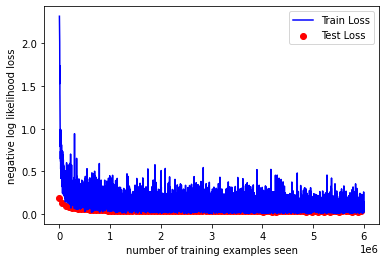

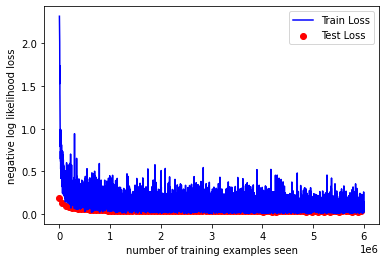

In [32]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig